# Skin Cancer Classification Challenge

**Summary : ** skin cancer.

## Preliminaries and Imports

In [1]:
#general & system\n",
import os

#data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data augmentation
from PIL import Image
from random import choice
import cv2
import numpy as np
#import keras.preprocessing.image as prep

#ML part
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image as kimage
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout,Activation,Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score


from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

%matplotlib inline

Using TensorFlow backend.


## I. Load Data

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [2]:
%%time
meta = pd.read_csv("../data/label_learn.csv", sep = ";")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 7.89 ms


In [3]:
meta.head()

,name,label
0,0000000.jpg,benign
1,0000002.jpg,malignant
2,0000006.jpg,benign
3,0000008.jpg,benign
4,0000009.jpg,benign


In [4]:
%%time
train_list = os.listdir("../data/resized_train/")
len(train_list) == len(meta.name)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 10.9 ms


In [5]:
train_list.sort() == list(meta.name).sort()

True

In [6]:
%%time
X_train = np.array([np.array(Image.open("../data/resized_train/"+fname)) for fname in meta.name])
Y_train = [1 if x=="malignant" else 0 for x in meta.label]

CPU times: user 17.9 s, sys: 1.25 s, total: 19.2 s
Wall time: 22.9 s


In [7]:
print(X_train.shape)
print(len(Y_train))
X_train.shape[0] == len(meta.name) == len(Y_train)

(8581, 299, 299, 3)
8581


True

In [8]:
#control
print(meta.name[0:5])
print(Y_train[0:5])
print(meta.label[0:5])

0    0000000.jpg
1    0000002.jpg
2    0000006.jpg
3    0000008.jpg
4    0000009.jpg
Name: name, dtype: object
[0, 1, 0, 0, 0]
0       benign
1    malignant
2       benign
3       benign
4       benign
Name: label, dtype: object


## II. Feature Exctraction

In [9]:
weights_path = '../model/checkpoints/'

if not os.path.exists(weights_path):
    os.makedirs(weights_path)

- **Using RESNET : **

In [10]:
from keras import backend as K

def weighted_categorical_crossentropy(weights):
    """
    [w_0, w_1] : weight of 0 class and weight of 1 class
    """
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights[1] + (1 - y_true) * K.log(1 - y_pred) * weights[0]
        loss = -K.sum(loss, -1)
        return loss

    return loss

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())




In [11]:
class_weight_or = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
loss1 = weighted_categorical_crossentropy(class_weight_or)

In [12]:
model = load_model(weights_path+"BestKerasResnet50_flat_2.h5", custom_objects={'sensitivity': sensitivity,
                                                                             "specificity":specificity,
                                                                              "loss1":loss1})
score = model.evaluate(X_train, Y_train, verbose=1)
print('Test loss:', score[0])
print('Test sensitivity:', score[1])
print('Test specificity:', score[2])
print('Test acc:', score[3])

8581/8581 [==============================] - 204s 24ms/step
('Test loss:', 0.10122663934359973)
('Test sensitivity:', 0.15313668440527717)
('Test specificity:', 0.98419247712306579)
('Test acc:', 0.95664840928325423)


## IV. Visualize  TSNE

In [13]:
%matplotlib inline
import numpy as np
# visualize the points' distribution of train data using features built from base_model
import matplotlib.pyplot as plt
# dimension reduction
from sklearn.manifold import TSNE 
import numpy as np

def t_sne_vis(name, base_model, x_processed_images, random_state, labels):
    """
    :param name: the name of the cnn model used to build features
    :param base_model: the model obj
    :param x_processed_images: the input images for our model
    :param random_state: for fixing the results
    :param labels: 0/1 classification labels
    :return:
    the graph of image distribution based on features extracted from the model and the t-sne features
    """
    # convert data to images
    print('Converting data points to composite image')
    X_train = x_processed_images
    print('we got %d different images of shape %dx%d ' % (len(X_train), X_train.shape[1], X_train.shape[1]))
    print('build usefull features from the selected model')
    features = base_model.predict(X_train,verbose = 1)
    x_data1 = np.asarray(features).astype('float64')
    x_data1 = x_data1.reshape((x_data1.shape[0], -1))
    # perform t-SNE embedding
    print('performing t-sne reduction')
    vis_data = TSNE(perplexity=100, random_state=random_state).fit_transform(x_data1)
    # plot the result
    fig = plt.figure(figsize=(15, 15))
    vis_x = vis_data[:, 0]
    vis_y = vis_data[:, 1]
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("winter", 2))
    plt.colorbar(ticks=range(2))
    plt.clim(0, 1)
    plt.title(name)
    plt.grid()
    plt.show()
    fig.savefig('tsne_vis_'+name+'.png')
    return vis_data


In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 150, 150, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

visualizing for Resnet
Converting data points to composite image
we got 8581 different images of shape 299x299 
build usefull features from the selected model


/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("av..., inputs=Tensor("in...)`
  This is separate from the ipykernel package so we can avoid doing imports until


8581/8581 [==============================] - 210s 24ms/step
performing t-sne reduction


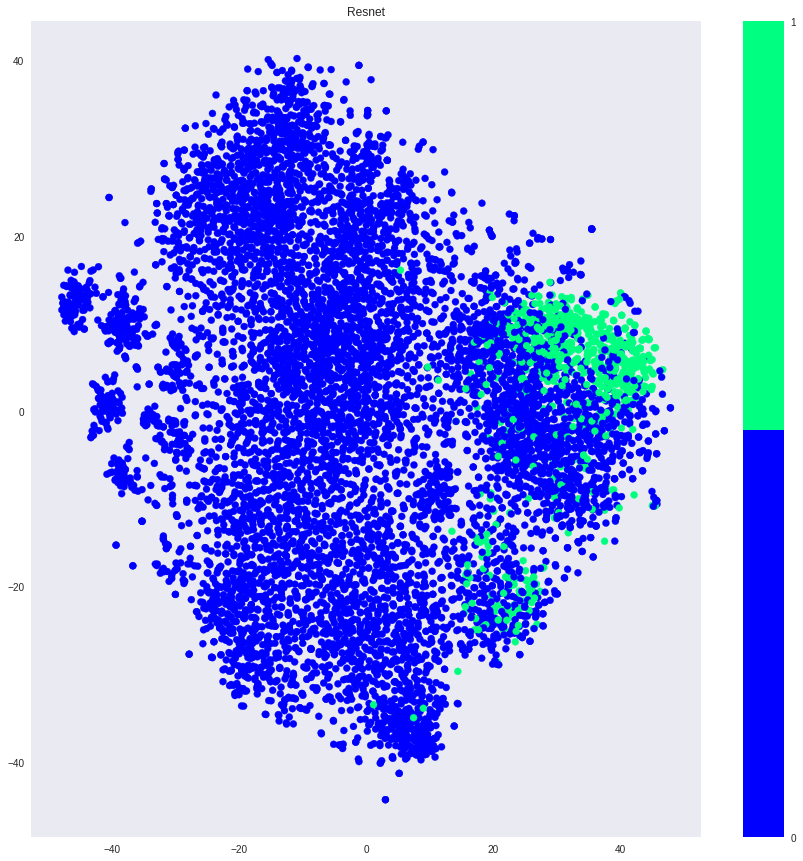

In [15]:
%%time
name = 'Resnet'
print('visualizing for %s' %name)
base_model_ = Model(input=model.input, output=model.get_layer('avg_pool').output)
tsne_feats = t_sne_vis(name, base_model_, X_train, np.random.RandomState(42), Y_train)

## III. Extract

In [17]:
df = pd.DataFrame()
features = base_model_.predict(X_train,verbose = 1)
df["name"]=meta.name
df["label"]= Y_train

In [23]:
features.shape

(8581, 1, 1, 2048)

In [32]:
features = features.reshape((8581,2048))

In [37]:
for i in range(features.shape[1]):
    df["feat_%s" %i] = features[:,i]

In [38]:
df.to_csv("../../weights/features1.csv",sep=",",index=False)

## VI. Submit